In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [2]:
#定义变量 
thermal_power_station_strategy=np.zeros(shape=(4,1000)) 
wind_power_station_strategy=np.zeros(shape=(2,1000))
c_wind_speed= np.loadtxt("./data/c_wind_speed_uniform_distribution_(3,25).txt")      
kappa_wind_speed= np.loadtxt("./data/kappa_wind_speed_uniform_distribution_(2,3).txt")  
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt") #时变的需求侧用电需求  阶梯式变化 
thermal_power_station_dual_variable=np.zeros(shape=(4,1000))
wind_power_station_dual_variable=np.zeros(shape=(2,1000))#两个风力发电站中有一个是受到拜占庭攻击的 假设第二个风力发电站是受到攻击的
E=np.loadtxt("6_Network_Topology_Double_Random_Adjacency_Matrix.txt")
thermal_power_station_cost=np.zeros(shape=(1,1000)) #火力发电成本
wind_power_station_cost=np.zeros(shape=(1,1000)) #风力发电成本
sum_cost=np.zeros(shape=(1,1000)) #总发电成本
#thermal_power_station_eta=[0.0375,0.0375,0.0625,0.035]
thermal_power_station_eta=[0.0675,0.0675,0.0925,0.0625]
thermal_power_station_zeta=[2,1.75,1,3]
thermal_power_station_xi=[0,0,0,0]
thermal_power_station_P_min=[50,20,15,10]
thermal_power_station_P_max=[200,120,80,100]
#wind_power_station_varphi=[3]
wind_power_station_varphi=[1]
wind_power_station_v_in=[3]
wind_power_station_v_out=[25]
wind_power_station_v_r=[13]
wind_power_station_sigma_ue=[5]
wind_power_station_sigma_oe=[30]
wind_power_station_P_r=[160]
wind_power_station_P_min=[0]
wind_power_station_P_max=[160]
sum_thermal_wind_power_station_strategy=np.zeros(shape=(1,1000))
step_size_primal=1
step_size_dual=1
regularization_parameter=0.001
large_Gaussian_Byzantine_attack=np.loadtxt("./data/large_Gaussian_Byzantine_attack_(-10,5).txt")

In [3]:
#火力，风力发电策略初始化
thermal_power_station_strategy[0][0]=0
thermal_power_station_strategy[1][0]=0
thermal_power_station_strategy[2][0]=0
thermal_power_station_strategy[3][0]=0
wind_power_station_strategy[0][0]=0
wind_power_station_strategy[1][0]=0
#初始总发电策略
sum_thermal_wind_power_station_strategy[0][0]=0
#初始化受到攻击的风力发电站的对偶变量
wind_power_station_dual_variable[1][0]=large_Gaussian_Byzantine_attack[0]

#火力，风力发电对偶初始化
thermal_power_station_dual_variable[0][0]=0
thermal_power_station_dual_variable[1][0]=0
thermal_power_station_dual_variable[2][0]=0
thermal_power_station_dual_variable[3][0]=0
wind_power_station_dual_variable[0][0]=0

#安全发电站的初始总发电成本
#火力发电成本
for i in range(0,4):
    thermal_power_station_cost[0][0]=thermal_power_station_cost[0][0]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][0]*thermal_power_station_strategy[i][0]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][0]
#风力发电成本
for i in range(0,1):
    wind_power_station_cost[0][0]=wind_power_station_cost[0][0]+wind_power_station_varphi[i]*wind_power_station_strategy[i][0]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_r[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][0])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_in[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))
#发电总成本
sum_cost[0][0]=thermal_power_station_cost[0][0]+wind_power_station_cost[0][0]

#计算每个发电站的邻居发电站
neighbor_robust1_help=[]
for i in range (0,6):
    for j in range (0,6):
        if E[i][j]!=0:
            neighbor_robust1_help.append(j)
        elif E[i][j]==0:
            neighbor_robust1_help.append(99)
neighbor_robust1=np.array(neighbor_robust1_help).reshape(6,6)

#计算安全的发电站的拜占庭邻居用户数量
q_robust1=[]
for i in range(0,6):
    q_robust1_help=0
    for j in range(0,6):
        if neighbor_robust1[i][j]==5:
            q_robust1_help=q_robust1_help+1
    q_robust1.append(q_robust1_help)

In [4]:
def IOS_Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual):
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("***************************attack_free_online_decentralized_economic_dispatch*****************************")
    print("相关变量初始值为：")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始计划发电量为:",thermal_power_station_strategy[i][0])
    for i in range (0,2):
        print("第",(i+5),"个风力发电站的初始计划发电量为:",wind_power_station_strategy[i][0])
    print("****************************************************************************")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[i][0])
    for i in range (0,1):
        print("第",(i+5),"个风力发电站的初始对偶变量为:",wind_power_station_dual_variable[i][0])
    print("****************************************************************************")
    print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][0])
    print("****************************************************************************")
    print("安全发电站的初始总发电量:",sum_thermal_wind_power_station_strategy[0][0])
    print("*************************")
    print("需求侧平均用电需求:",d_power_demand[0])
    print("****************************************************************************")
    print("风速分布参数c:",c_wind_speed[0])
    print("****************************************************************************")
    print("风速分布参数kappa:",kappa_wind_speed[0])
    print("****************************************************************************")
    print("安全发电站的总发电成本：", sum_cost[0][0])
    print("****************************************************************************")
    print("原变量迭代步长为:",step_size_primal)
    print("*****************************************************************************")
    print("对偶变量迭代步长为:",step_size_dual)
    print("*****************************************************************************")
    
    #开始迭代
    for k in range(1,1000):
        #发电站更新计划发电量和对偶变量
        #对偶变量 先做梯度上升 再做聚合
        #安全发电站的梯度上升
        dual_variable_intermediate=[] #存放当前迭代中6个用户对对偶变量做完梯度下降后得到的中间值
        for i in range(0,4):
            dual_variable_intermediate.append(thermal_power_station_dual_variable[i][k-1]+step_size_dual*((1/6)*thermal_power_station_strategy[i][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*thermal_power_station_dual_variable[i][k-1]))
        for j in range(0,1):
            dual_variable_intermediate.append(wind_power_station_dual_variable[j][k-1]+step_size_dual*((1/6)*wind_power_station_strategy[j][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*wind_power_station_dual_variable[j][k-1]))
        #受到攻击的风力发电站的对偶值
        dual_variable_intermediate.append(wind_power_station_dual_variable[1][k-1])
        
        #IOS鲁棒聚合 安全的火力发电站的对偶更新    
        for i in range (0,4):
            u_neighbor_help_robust1=neighbor_robust1[i].tolist()#将用户i的邻居序号存在辅助变量u中
            if i==0 or i==3:
                u_neighbor_help_robust1 = list(set(u_neighbor_help_robust1))
                u_neighbor_help_robust1.remove(99)
            #u_neighbor_help_robust1.append(i)
            for q in range(0, int(q_robust1[i])):#剔除q个邻居的信息
                #计算当前的h-权重
                dual_variable_weight_average_robust1=0
                h_robust1=0
                for j in range(0,len(u_neighbor_help_robust1)):#计算当前循环中的h值
                    h_robust1=h_robust1+E[i][u_neighbor_help_robust1[j]]
                for j in range(0,len(u_neighbor_help_robust1)):#计算当前循环中的对偶权重平均值
                    dual_variable_weight_average_robust1=dual_variable_weight_average_robust1+(1/h_robust1)*(E[i][u_neighbor_help_robust1[j]]*dual_variable_intermediate[u_neighbor_help_robust1[j]])
                #剔除一个对偶值离权重平均对偶值最远的用户 保留自身的值
                u_neighbor_help_robust1.remove(i)
                neighbor_index_robust1=u_neighbor_help_robust1[0]
                max_distance_roubust1=abs(dual_variable_intermediate[u_neighbor_help_robust1[0]]-dual_variable_weight_average_robust1)
                for j in range(1,len(u_neighbor_help_robust1)):
                    if abs(dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_weight_average_robust1)>=max_distance_roubust1:
                        max_distance_roubust1=abs(dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_weight_average_robust1)
                        neighbor_index_robust1=u_neighbor_help_robust1[j]
                u_neighbor_help_robust1.remove(neighbor_index_robust1)
                u_neighbor_help_robust1.append(i)
            #计算剔除q个信息后的权重平均对偶值
            dual_variable_weight_average_robust1=0
            h_robust1=0
            for j in range(0,len(u_neighbor_help_robust1)):
                h_robust1=h_robust1+E[i][u_neighbor_help_robust1[j]]
            for j in range(0,len(u_neighbor_help_robust1)):
                dual_variable_weight_average_robust1=dual_variable_weight_average_robust1+(1/h_robust1)*(E[i][u_neighbor_help_robust1[j]]*dual_variable_intermediate[u_neighbor_help_robust1[j]])     
            #诚实用户基于IOS鲁棒聚合后的值进行自身的对偶变量的更新 基于权重平均值
            thermal_power_station_dual_variable[i][k]=dual_variable_weight_average_robust1     

        #聚合 安全的风力发电站的对偶更新
        for i in range(0,1):
            u_neighbor_help_robust1=neighbor_robust1[i+4].tolist()#将用户i的邻居序号存在辅助变量u中
            u_neighbor_help_robust1 = list(set(u_neighbor_help_robust1))
            u_neighbor_help_robust1.remove(99)
            dual_variable_weight_average_robust1=0
            h_robust1=0
            for j in range(0,len(u_neighbor_help_robust1)):
                h_robust1=h_robust1+E[i][u_neighbor_help_robust1[j]]               
            for j in range(0,len(u_neighbor_help_robust1)):
                dual_variable_weight_average_robust1=dual_variable_weight_average_robust1+(1/h_robust1)*(E[i][u_neighbor_help_robust1[j]]*dual_variable_intermediate[u_neighbor_help_robust1[j]])     
            wind_power_station_dual_variable[i][k]=dual_variable_weight_average_robust1
        #受到Byzantine攻击的风力发电站的对偶更新
        wind_power_station_dual_variable[1][k]=large_Gaussian_Byzantine_attack[k]          
        
        #安全的火力发电站计划发电量
        for i in range(0,4):
            thermal_power_station_strategy[i][k]=thermal_power_station_strategy[i][k-1]-step_size_primal*(2*thermal_power_station_eta[i]*thermal_power_station_strategy[i][k-1]+thermal_power_station_zeta[i]+(1/6)*thermal_power_station_dual_variable[i][k-1]) 
            if thermal_power_station_strategy[i][k]<=thermal_power_station_P_min[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_min[i]
            elif thermal_power_station_strategy[i][k]>=thermal_power_station_P_max[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_max[i]
        #安全的风力发电站计划发电量
        for i in range(0,1):
            wind_power_station_strategy[i][k]=wind_power_station_strategy[i][k-1]-step_size_primal*(wind_power_station_varphi[i]+wind_power_station_sigma_oe[i]+(wind_power_station_sigma_ue[i]+wind_power_station_sigma_oe[i])*math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(-wind_power_station_sigma_ue[i]-wind_power_station_sigma_oe[i])*math.exp(-(math.pow((wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k-1])/wind_power_station_P_r[i]),kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(1/6)*wind_power_station_dual_variable[i][k-1])
            if wind_power_station_strategy[i][k]<=wind_power_station_P_min[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_min[i]
            elif wind_power_station_strategy[i][k]>=wind_power_station_P_max[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_max[i]
        #受到Byzantine攻击的风力发电站的计划发电量
        wind_power_station_strategy[1][k]=wind_power_station_strategy[1][k-1]
        
        #安全发电站的计算总计划发电
        #火力发电量
        for i in range(0,4):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+thermal_power_station_strategy[i][k]
        #风力发电量
        for i in range(0,1):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+wind_power_station_strategy[i][k]
        
        #安全发电站的计算总发电成本
        #火力发电成本
        for i in range(0,4):
            thermal_power_station_cost[0][k]=thermal_power_station_cost[0][k]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][k]*thermal_power_station_strategy[i][k]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][k]
        #风力发电成本
        for i in range(0,1):
            wind_power_station_cost[0][k]=wind_power_station_cost[0][k]+wind_power_station_varphi[i]*wind_power_station_strategy[i][k]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_r[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][k])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_in[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))
        #发电总成本
        sum_cost[0][k]=thermal_power_station_cost[0][k]+wind_power_station_cost[0][k]
        
        #输出第k次迭代中的结果 每间隔10次迭代输出一次结果
        #if (k+1)%10==0:
        print(k,"次迭代中的结果：")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的计划发电量为:",thermal_power_station_strategy[i][k])
        for i in range (0,2):
            print("第",(i+5),"个风力发电站的计划发电量为:",wind_power_station_strategy[i][k])
        print("****************************************************************************")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的对偶变量为:",thermal_power_station_dual_variable[i][k])
        for i in range (0,1):
            print("第",(i+5),"个风力发电站的对偶变量为:",wind_power_station_dual_variable[i][k])
        print("****************************************************************************")
        print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][k])
        print("****************************************************************************")
        print("安全发电站的总发电量:",sum_thermal_wind_power_station_strategy[0][k])
        print("*************************")
        print("需求侧平均用电需求:",d_power_demand[k])
        print("****************************************************************************")
        print("风速分布参数c:",c_wind_speed[k])
        print("****************************************************************************")
        print("风速分布参数kappa:",kappa_wind_speed[k])
        print("****************************************************************************")        
        print("安全发电站的总发电成本：", sum_cost[0][k])
        print("****************************************************************************")
        print("原变量迭代步长为:",step_size_primal)
        print("****************************************************************************")
        print("对偶变量迭代步长为:",step_size_dual)
        print("****************************************************************************")
        
        #step_size_primal=(pow(k+1,0.1))
        #step_size_dual=1/(pow(k+1,0.7))#我们发现在在线算法中 不能使用太小的对偶步长 不然后续算法对在线变化会不敏感 
        
        '''#尝试使用两阶段的步长
        if k<=500:
            step_size_dual=1/(pow(k+1,0.7))
        else:
            step_size_dual=0.1'''

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
    return None  

In [5]:
IOS_Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual)

***************************attack_free_online_decentralized_economic_dispatch*****************************
相关变量初始值为：
第 1 个火力发电站的初始计划发电量为: 0.0
第 2 个火力发电站的初始计划发电量为: 0.0
第 3 个火力发电站的初始计划发电量为: 0.0
第 4 个火力发电站的初始计划发电量为: 0.0
第 5 个风力发电站的初始计划发电量为: 0.0
第 6 个风力发电站的初始计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的初始对偶变量为: 0.0
第 2 个火力发电站的初始对偶变量为: 0.0
第 3 个火力发电站的初始对偶变量为: 0.0
第 4 个火力发电站的初始对偶变量为: 0.0
第 5 个风力发电站的初始对偶变量为: 0.0
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -4.09660692
****************************************************************************
安全发电站的初始总发电量: 0.0
*************************
需求侧平均用电需求: 72.62781256
****************************************************************************
风速分布参数c: 8.301041
****************************************************************************
风速分布参数kappa: 2.66836324
**************************************************************************

****************************************************************************
安全发电站的总发电量: 396.46828563336527
*************************
需求侧平均用电需求: 76.57534104
****************************************************************************
风速分布参数c: 11.11125981
****************************************************************************
风速分布参数kappa: 2.9635753
****************************************************************************
安全发电站的总发电成本： 3083.126064891739
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
27 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 86.39048355448621
第 2 个火力发电站的计划发电量为: 87.34438467099173
第 3 个火力发电站的计划发电量为: 68.95161494181765
第 4 个火力发电站的计划发电量为: 83.69456616785526
第 5 个风力发电站的计划发电量为: 75.95763618357235
第 6 个风力发电站的计划发电量为: 0.0
*************************************************************

对偶变量迭代步长为: 1
****************************************************************************
47 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 64.28669487444802
第 2 个火力发电站的计划发电量为: 66.8090744363017
第 3 个火力发电站的计划发电量为: 51.27743264943315
第 4 个火力发电站的计划发电量为: 63.9388885048735
第 5 个风力发电站的计划发电量为: 85.29806255585461
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -61.81992050482426
第 2 个火力发电站的对偶变量为: -62.45917615055181
第 3 个火力发电站的对偶变量为: -62.19632792334616
第 4 个火力发电站的对偶变量为: -63.612509432384044
第 5 个风力发电站的对偶变量为: -61.81992050482426
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -10.01412096
****************************************************************************
安全发电站的总发电量: 331.61015302091096
*************************
需求侧平均用电需求: 72.17116496
****************************************************************************
风速分布参数c: 3.86330913
****************************************************

第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -6.54901688
****************************************************************************
安全发电站的总发电量: 385.45627574341023
*************************
需求侧平均用电需求: 77.16414749
****************************************************************************
风速分布参数c: 19.37563419
****************************************************************************
风速分布参数kappa: 2.00021162
****************************************************************************
安全发电站的总发电成本： 3123.3456446890027
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
72 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 67.98925472895078
第 2 个火力发电站的计划发电量为: 70.99187488311296
第 3 个火力发电站的计划发电量为: 54.59920918721064
第 4 个火力发电站的计划发电量为: 69.28738432514082
第 5 个风力发电站的计划发电量为: 115.25104609751796
第 6 个风力发电站的计划发电量为: 0.0
*************

对偶变量迭代步长为: 1
****************************************************************************
101 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 73.43868060651745
第 2 个火力发电站的计划发电量为: 75.89709072167084
第 3 个火力发电站的计划发电量为: 59.819374236093836
第 4 个火力发电站的计划发电量为: 72.77904422063405
第 5 个风力发电站的计划发电量为: 98.75006477384987
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -69.26718280816259
第 2 个火力发电站的对偶变量为: -70.04694427363326
第 3 个火力发电站的对偶变量为: -69.78101368840372
第 4 个火力发电站的对偶变量为: -71.60428580395902
第 5 个风力发电站的对偶变量为: -69.26718280816259
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -11.36706279
****************************************************************************
安全发电站的总发电量: 380.68425455876604
*************************
需求侧平均用电需求: 66.91223509
****************************************************************************
风速分布参数c: 24.25524597
************************************************

第 3 个火力发电站的对偶变量为: -77.21926396442788
第 4 个火力发电站的对偶变量为: -77.90047510984661
第 5 个风力发电站的对偶变量为: -77.17374762707672
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -4.31850432
****************************************************************************
安全发电站的总发电量: 349.7790830620774
*************************
需求侧平均用电需求: 66.20961339
****************************************************************************
风速分布参数c: 12.45151853
****************************************************************************
风速分布参数kappa: 2.64873514
****************************************************************************
安全发电站的总发电成本： 2534.878382832908
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
126 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 75.8548974803764

第 4 个火力发电站的对偶变量为: -66.04455653787916
第 5 个风力发电站的对偶变量为: -64.51280679613127
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -9.67064129
****************************************************************************
安全发电站的总发电量: 334.128011222086
*************************
需求侧平均用电需求: 72.24897657
****************************************************************************
风速分布参数c: 9.00811975
****************************************************************************
风速分布参数kappa: 2.09998952
****************************************************************************
安全发电站的总发电成本： 2540.09360270594
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
151 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 69.498219387966
第 2 个火力发电站的计划发电量为: 71.65305233191596
第 3

原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
182 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 69.679117330185
第 2 个火力发电站的计划发电量为: 72.32349056956122
第 3 个火力发电站的计划发电量为: 55.755124993680155
第 4 个火力发电站的计划发电量为: 69.79157838186642
第 5 个风力发电站的计划发电量为: 97.23678751932981
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -63.76529448571917
第 2 个火力发电站的对偶变量为: -64.68111431322744
第 3 个火力发电站的对偶变量为: -64.40293479250457
第 4 个火力发电站的对偶变量为: -66.45131983049701
第 5 个风力发电站的对偶变量为: -63.76529448571917
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -11.52718426
****************************************************************************
安全发电站的总发电量: 364.7860987946226
*************************
需求侧平均用电需求: 77.54093239
************************************************************

第 2 个火力发电站的对偶变量为: -67.16042156238548
第 3 个火力发电站的对偶变量为: -66.90397482281553
第 4 个火力发电站的对偶变量为: -69.14763719772301
第 5 个风力发电站的对偶变量为: -66.0140063332169
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -9.91086885
****************************************************************************
安全发电站的总发电量: 340.4793756902627
*************************
需求侧平均用电需求: 64.46339042
****************************************************************************
风速分布参数c: 13.15398398
****************************************************************************
风速分布参数kappa: 2.85638928
****************************************************************************
安全发电站的总发电成本： 2303.5004473936824
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
214 次迭代中的结果

第 3 个火力发电站的计划发电量为: 55.16645238622764
第 4 个火力发电站的计划发电量为: 65.76341320775984
第 5 个风力发电站的计划发电量为: 66.5790340211078
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -71.81940918909686
第 2 个火力发电站的对偶变量为: -71.8436450841599
第 3 个火力发电站的对偶变量为: -71.6111875193882
第 4 个火力发电站的对偶变量为: -71.61333020557237
第 5 个风力发电站的对偶变量为: -71.81940918909686
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -7.77688002
****************************************************************************
安全发电站的总发电量: 323.44265538585427
*************************
需求侧平均用电需求: 68.0905304
****************************************************************************
风速分布参数c: 17.46487804
****************************************************************************
风速分布参数kappa: 2.22160889
****************************************************************************
安全发电站的总发电成本： 2394.2287893146276
*********************

第 2 个火力发电站的计划发电量为: 69.39626751480571
第 3 个火力发电站的计划发电量为: 53.448671260731594
第 4 个火力发电站的计划发电量为: 66.95056843361414
第 5 个风力发电站的计划发电量为: 106.6761948696384
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -62.54099382743962
第 2 个火力发电站的对偶变量为: -63.60515916694582
第 3 个火力发电站的对偶变量为: -63.33646440501735
第 4 个火力发电站的对偶变量为: -65.78389592954453
第 5 个风力发电站的对偶变量为: -62.54099382743962
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -6.78755967
****************************************************************************
安全发电站的总发电量: 363.1350655995369
*************************
需求侧平均用电需求: 65.29021658
****************************************************************************
风速分布参数c: 12.20784506
****************************************************************************
风速分布参数kappa: 2.53496922
****************************************************************************
安全发电站的总发电成本：

****************************************************************************
298 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 73.28426067702789
第 2 个火力发电站的计划发电量为: 75.5851679977676
第 3 个火力发电站的计划发电量为: 59.88023566088059
第 4 个火力发电站的计划发电量为: 71.97962064774835
第 5 个风力发电站的计划发电量为: 80.28351059444334
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -74.96606814739016
第 2 个火力发电站的对偶变量为: -75.11571202929163
第 3 个火力发电站的对偶变量为: -74.85647652846062
第 4 个火力发电站的对偶变量为: -75.18764998514861
第 5 个风力发电站的对偶变量为: -74.96606814739016
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -11.86984917
****************************************************************************
安全发电站的总发电量: 361.01279557786773
*************************
需求侧平均用电需求: 61.68649505
****************************************************************************
风速分布参数c: 6.32188959
****************************************************************

第 2 个火力发电站的对偶变量为: -69.68716667406699
第 3 个火力发电站的对偶变量为: -69.39692129812731
第 4 个火力发电站的对偶变量为: -70.56178397691527
第 5 个风力发电站的对偶变量为: -69.17842997970918
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -11.27022314
****************************************************************************
安全发电站的总发电量: 379.8986880614964
*************************
需求侧平均用电需求: 70.91305629
****************************************************************************
风速分布参数c: 20.12935389
****************************************************************************
风速分布参数kappa: 2.0998741
****************************************************************************
安全发电站的总发电成本： 3100.089364131806
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
319 次迭代中的结果

第 1 个火力发电站的对偶变量为: -61.87829635986315
第 2 个火力发电站的对偶变量为: -62.78890299963896
第 3 个火力发电站的对偶变量为: -62.53242130624676
第 4 个火力发电站的对偶变量为: -64.46555317648165
第 5 个风力发电站的对偶变量为: -61.87829635986315
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -15.30902379
****************************************************************************
安全发电站的总发电量: 339.45743572612304
*************************
需求侧平均用电需求: 67.47187481
****************************************************************************
风速分布参数c: 4.55358071
****************************************************************************
风速分布参数kappa: 2.16768807
****************************************************************************
安全发电站的总发电成本： 3731.603211023922
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
**************************************************

第 4 个火力发电站的对偶变量为: -73.05927914799955
第 5 个风力发电站的对偶变量为: -72.54388229373598
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -3.76060949
****************************************************************************
安全发电站的总发电量: 366.8392304394273
*************************
需求侧平均用电需求: 73.493011
****************************************************************************
风速分布参数c: 19.71237245
****************************************************************************
风速分布参数kappa: 2.00940798
****************************************************************************
安全发电站的总发电成本： 3008.223572119869
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
369 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 76.26782761888975
第 2 个火力发电站的计划发电量为: 78.00487882183897


第 3 个火力发电站的计划发电量为: 50.924094253055
第 4 个火力发电站的计划发电量为: 63.30699294365229
第 5 个风力发电站的计划发电量为: 99.49158425959236
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -62.01651135746487
第 2 个火力发电站的对偶变量为: -63.05350539141779
第 3 个火力发电站的对偶变量为: -62.80930829517132
第 4 个火力发电站的对偶变量为: -65.17291427760995
第 5 个风力发电站的对偶变量为: -62.01651135746487
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -14.21399139
****************************************************************************
安全发电站的总发电量: 341.63775340212334
*************************
需求侧平均用电需求: 70.91012053
****************************************************************************
风速分布参数c: 21.90328039
****************************************************************************
风速分布参数kappa: 2.02990755
****************************************************************************
安全发电站的总发电成本： 2813.9397975291504
******************

原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
411 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 65.17085774967676
第 2 个火力发电站的计划发电量为: 68.10192562167333
第 3 个火力发电站的计划发电量为: 53.83180816445295
第 4 个火力发电站的计划发电量为: 65.71365161060433
第 5 个风力发电站的计划发电量为: 53.24832989402238
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -68.94355791328218
第 2 个火力发电站的对偶变量为: -69.30968617564578
第 3 个火力发电站的对偶变量为: -69.07248669941852
第 4 个火力发电站的对偶变量为: -69.81349159242998
第 5 个风力发电站的对偶变量为: -68.94355791328218
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -12.8406533
****************************************************************************
安全发电站的总发电量: 306.0665730404298
*************************
需求侧平均用电需求: 68.7281519
*************************************************************

安全发电站的总发电量: 370.15179301831427
*************************
需求侧平均用电需求: 71.31208171
****************************************************************************
风速分布参数c: 23.41279704
****************************************************************************
风速分布参数kappa: 2.3421637
****************************************************************************
安全发电站的总发电成本： 3177.898126388728
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
431 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 71.33137926383117
第 2 个火力发电站的计划发电量为: 73.99852392770669
第 3 个火力发电站的计划发电量为: 57.608662489673236
第 4 个火力发电站的计划发电量为: 71.47319307920036
第 5 个风力发电站的计划发电量为: 93.46936809122816
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -64.87917898753045
第 2 个火力发电站的对偶变量为: -65.

原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
451 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 64.25913480364416
第 2 个火力发电站的计划发电量为: 67.06288400321762
第 3 个火力发电站的计划发电量为: 52.627882255750585
第 4 个火力发电站的计划发电量为: 64.41791917966883
第 5 个风力发电站的计划发电量为: 90.43130862897496
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -66.63072337459347
第 2 个火力发电站的对偶变量为: -67.43630315171228
第 3 个火力发电站的对偶变量为: -67.19493740547418
第 4 个火力发电站的对偶变量为: -68.89072437711911
第 5 个风力发电站的对偶变量为: -66.63072337459347
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -1.32224965
****************************************************************************
安全发电站的总发电量: 338.79912887125613
*************************
需求侧平均用电需求: 67.05431856
**********************************************************

第 5 个风力发电站的计划发电量为: 70.53697418049886
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -75.95934738197712
第 2 个火力发电站的对偶变量为: -75.89529275977192
第 3 个火力发电站的对偶变量为: -75.63374122881409
第 4 个火力发电站的对偶变量为: -75.38378636621019
第 5 个风力发电站的对偶变量为: -75.95934738197712
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -11.01026426
****************************************************************************
安全发电站的总发电量: 351.96398881825974
*************************
需求侧平均用电需求: 71.4935871
****************************************************************************
风速分布参数c: 23.99378109
****************************************************************************
风速分布参数kappa: 2.92417084
****************************************************************************
安全发电站的总发电成本： 3015.6092045188007
****************************************************************************
原变量迭代步长为: 1
**

第 3 个火力发电站的计划发电量为: 53.93869754794939
第 4 个火力发电站的计划发电量为: 65.96750356424641
第 5 个风力发电站的计划发电量为: 65.93635937312627
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -67.42303846403523
第 2 个火力发电站的对偶变量为: -68.01918488544351
第 3 个火力发电站的对偶变量为: -67.76643795972372
第 4 个火力发电站的对偶变量为: -68.88708299735583
第 5 个风力发电站的对偶变量为: -67.42303846403523
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -8.94197583
****************************************************************************
安全发电站的总发电量: 321.37106331250857
*************************
需求侧平均用电需求: 67.59458178
****************************************************************************
风速分布参数c: 7.5439514
****************************************************************************
风速分布参数kappa: 2.66690917
****************************************************************************
安全发电站的总发电成本： 2406.5059816769644
*******************

第 2 个火力发电站的计划发电量为: 72.79562803777314
第 3 个火力发电站的计划发电量为: 56.661992101861806
第 4 个火力发电站的计划发电量为: 69.50639060426549
第 5 个风力发电站的计划发电量为: 82.87395283715819
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -66.60561083013815
第 2 个火力发电站的对偶变量为: -67.16317636232978
第 3 个火力发电站的对偶变量为: -66.89373888749662
第 4 个火力发电站的对偶变量为: -68.10960718530487
第 5 个风力发电站的对偶变量为: -66.60561083013815
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -7.83710334
****************************************************************************
安全发电站的总发电量: 352.2498475207969
*************************
需求侧平均用电需求: 74.99275122
****************************************************************************
风速分布参数c: 18.78206109
****************************************************************************
风速分布参数kappa: 2.84960778
****************************************************************************
安全发电站的总发电成本：

第 4 个火力发电站的对偶变量为: -69.06032365717297
第 5 个风力发电站的对偶变量为: -66.83644574794037
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -9.38666342
****************************************************************************
安全发电站的总发电量: 357.3356175366839
*************************
需求侧平均用电需求: 76.13632322
****************************************************************************
风速分布参数c: 6.6212509
****************************************************************************
风速分布参数kappa: 2.18849027
****************************************************************************
安全发电站的总发电成本： 3360.2468844893615
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
550 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 68.69817991074464
第 2 个火力发电站的计划发电量为: 71.13291111540593

风速分布参数kappa: 2.41145051
****************************************************************************
安全发电站的总发电成本： 2947.107101166873
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
571 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 70.359477186715
第 2 个火力发电站的计划发电量为: 72.90405404162951
第 3 个火力发电站的计划发电量为: 56.814714442422215
第 4 个火力发电站的计划发电量为: 70.0491062064758
第 5 个风力发电站的计划发电量为: 93.53140641385426
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -68.0235314211197
第 2 个火力发电站的对偶变量为: -68.95980921741534
第 3 个火力发电站的对偶变量为: -68.69112737340653
第 4 个火力发电站的对偶变量为: -70.84590541208044
第 5 个风力发电站的对偶变量为: -68.0235314211197
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -8.45367438
***********

第 4 个火力发电站的计划发电量为: 69.51442022519933
第 5 个风力发电站的计划发电量为: 86.60387943349474
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -69.8378716538439
第 2 个火力发电站的对偶变量为: -70.29341542977504
第 3 个火力发电站的对偶变量为: -70.0348118097919
第 4 个火力发电站的对偶变量为: -71.0201739758279
第 5 个风力发电站的对偶变量为: -69.8378716538439
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -12.97136972
****************************************************************************
安全发电站的总发电量: 357.58346095661074
*************************
需求侧平均用电需求: 72.66894198
****************************************************************************
风速分布参数c: 18.60374249
****************************************************************************
风速分布参数kappa: 2.72469064
****************************************************************************
安全发电站的总发电成本： 2578.496416071981
**********************************************************

****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
626 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 70.78928665255921
第 2 个火力发电站的计划发电量为: 73.26001229487213
第 3 个火力发电站的计划发电量为: 57.990045514352474
第 4 个火力发电站的计划发电量为: 70.0472918523507
第 5 个风力发电站的计划发电量为: 80.50550066561306
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -73.48830642179367
第 2 个火力发电站的对偶变量为: -73.68833473584384
第 3 个火力发电站的对偶变量为: -73.43549064957611
第 4 个火力发电站的对偶变量为: -73.99756975799411
第 5 个风力发电站的对偶变量为: -73.48830642179367
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -3.29543335
****************************************************************************
安全发电站的总发电量: 352.5921369797475
*************************
需求侧平均用

第 5 个风力发电站的对偶变量为: -61.71860162286486
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -10.63655024
****************************************************************************
安全发电站的总发电量: 354.4756301815202
*************************
需求侧平均用电需求: 66.64654549
****************************************************************************
风速分布参数c: 19.79472478
****************************************************************************
风速分布参数kappa: 2.5171424
****************************************************************************
安全发电站的总发电成本： 2632.7228829989276
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
646 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 66.09599154030676
第 2 个火力发电站的计划发电量为: 69.0792544554485
第 3 个火力发电站的计划发电量为: 53.4395934729770

第 4 个火力发电站的计划发电量为: 76.6589277275935
第 5 个风力发电站的计划发电量为: 112.97379013190339
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -75.4777548217825
第 2 个火力发电站的对偶变量为: -76.37766122493628
第 3 个火力发电站的对偶变量为: -76.10787180161114
第 4 个火力发电站的对偶变量为: -78.18237341673313
第 5 个风力发电站的对偶变量为: -75.4777548217825
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -13.86274054
****************************************************************************
安全发电站的总发电量: 411.52944021809435
*************************
需求侧平均用电需求: 69.92606577
****************************************************************************
风速分布参数c: 21.53034529
****************************************************************************
风速分布参数kappa: 2.16956672
****************************************************************************
安全发电站的总发电成本： 3533.3590476522145
*******************************************************

第 3 个火力发电站的对偶变量为: -68.02916016107119
第 4 个火力发电站的对偶变量为: -68.70307762235878
第 5 个风力发电站的对偶变量为: -67.94365706433439
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -8.2522317
****************************************************************************
安全发电站的总发电量: 307.2114684451271
*************************
需求侧平均用电需求: 71.83714915
****************************************************************************
风速分布参数c: 6.5275571
****************************************************************************
风速分布参数kappa: 2.5491482
****************************************************************************
安全发电站的总发电成本： 2458.3888461230617
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
690 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 62.65882527007301
第

第 5 个风力发电站的对偶变量为: -75.21728431438162
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -16.06554532
****************************************************************************
安全发电站的总发电量: 361.5865632785354
*************************
需求侧平均用电需求: 71.64215386
****************************************************************************
风速分布参数c: 9.26686397
****************************************************************************
风速分布参数kappa: 2.39883923
****************************************************************************
安全发电站的总发电成本： 2784.199632996702
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
710 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 74.2082716166634
第 2 个火力发电站的计划发电量为: 76.48959503534002
第 3 个火力发电站的计划发电量为: 60.0598741924566


第 2 个火力发电站的计划发电量为: 74.22033493718257
第 3 个火力发电站的计划发电量为: 58.70514288583435
第 4 个火力发电站的计划发电量为: 69.78016666942351
第 5 个风力发电站的计划发电量为: 61.44261618102547
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -76.3100475087817
第 2 个火力发电站的对偶变量为: -76.03240653293665
第 3 个火力发电站的对偶变量为: -75.77548049825248
第 4 个火力发电站的对偶变量为: -75.12541955802226
第 5 个风力发电站的对偶变量为: -76.3100475087817
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -13.68471826
****************************************************************************
安全发电站的总发电量: 336.4099093396325
*************************
需求侧平均用电需求: 69.72840446
****************************************************************************
风速分布参数c: 12.7072184
****************************************************************************
风速分布参数kappa: 2.03419212
****************************************************************************
安全发电站的总发电成本： 25

第 3 个火力发电站的对偶变量为: -62.38053238572631
第 4 个火力发电站的对偶变量为: -63.0692243103056
第 5 个风力发电站的对偶变量为: -62.363176345871416
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -12.24499032
****************************************************************************
安全发电站的总发电量: 319.7597904312179
*************************
需求侧平均用电需求: 71.24901661
****************************************************************************
风速分布参数c: 24.99045541
****************************************************************************
风速分布参数kappa: 2.49526976
****************************************************************************
安全发电站的总发电成本： 2728.446372525741
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
760 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 64.048206931828

第 3 个火力发电站的计划发电量为: 59.868945676458125
第 4 个火力发电站的计划发电量为: 73.67122381268423
第 5 个风力发电站的计划发电量为: 76.98573669489892
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -66.6131104980546
第 2 个火力发电站的对偶变量为: -67.31940829170097
第 3 个火力发电站的对偶变量为: -67.0336972164603
第 4 个火力发电站的对偶变量为: -68.676833898305
第 5 个风力发电站的对偶变量为: -66.6131104980546
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -11.99673102
****************************************************************************
安全发电站的总发电量: 362.30530228681323
*************************
需求侧平均用电需求: 69.61122501
****************************************************************************
风速分布参数c: 6.47571971
****************************************************************************
风速分布参数kappa: 2.90082133
****************************************************************************
安全发电站的总发电成本： 3152.2384117953197
*********************

原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
810 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 76.44221116266894
第 2 个火力发电站的计划发电量为: 77.98747994652298
第 3 个火力发电站的计划发电量为: 61.78567089404689
第 4 个火力发电站的计划发电量为: 72.73015752373655
第 5 个风力发电站的计划发电量为: 77.68983125159241
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -77.55131178102958
第 2 个火力发电站的对偶变量为: -77.5695354227155
第 3 个火力发电站的对偶变量为: -77.3024754028002
第 4 个火力发电站的对偶变量为: -77.34301262030283
第 5 个风力发电站的对偶变量为: -77.55131178102958
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -16.23921376
****************************************************************************
安全发电站的总发电量: 366.6353507785678
*************************
需求侧平均用电需求: 68.01200992
*************************************************************

****************************************************************************
第 1 个火力发电站的对偶变量为: -66.57100737354395
第 2 个火力发电站的对偶变量为: -67.70696033266174
第 3 个火力发电站的对偶变量为: -67.48430129685588
第 4 个火力发电站的对偶变量为: -70.12541818492326
第 5 个风力发电站的对偶变量为: -66.57100737354395
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -8.9451633
****************************************************************************
安全发电站的总发电量: 341.24027252746794
*************************
需求侧平均用电需求: 69.99670793
****************************************************************************
风速分布参数c: 23.70781864
****************************************************************************
风速分布参数kappa: 2.96236642
****************************************************************************
安全发电站的总发电成本： 2778.8802691993587
****************************************************************************
原变量迭代步长为: 1
***************************************************************

第 1 个火力发电站的对偶变量为: -62.48173928258397
第 2 个火力发电站的对偶变量为: -63.451011300324154
第 3 个火力发电站的对偶变量为: -63.21800044657954
第 4 个火力发电站的对偶变量为: -65.31512371518494
第 5 个风力发电站的对偶变量为: -62.48173928258397
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -12.75645982
****************************************************************************
安全发电站的总发电量: 344.7548995799701
*************************
需求侧平均用电需求: 63.5555245
****************************************************************************
风速分布参数c: 12.00019977
****************************************************************************
风速分布参数kappa: 2.03649877
****************************************************************************
安全发电站的总发电成本： 2506.4646043239572
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
*************************************************

第 3 个火力发电站的计划发电量为: 59.031129401283096
第 4 个火力发电站的计划发电量为: 70.71943015090068
第 5 个风力发电站的计划发电量为: 76.72460030145108
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -73.75431044737732
第 2 个火力发电站的对偶变量为: -74.09405182180188
第 3 个火力发电站的对偶变量为: -73.83924423127874
第 4 个火力发电站的对偶变量为: -74.5586315821795
第 5 个风力发电站的对偶变量为: -73.75431044737732
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -13.07921153
****************************************************************************
安全发电站的总发电量: 353.13403850954325
*************************
需求侧平均用电需求: 72.84245786
****************************************************************************
风速分布参数c: 10.90389066
****************************************************************************
风速分布参数kappa: 2.62088506
****************************************************************************
安全发电站的总发电成本： 2527.328178768718
*****************

第 3 个火力发电站的对偶变量为: -63.84140248239141
第 4 个火力发电站的对偶变量为: -65.30171907580458
第 5 个风力发电站的对偶变量为: -63.45746404915289
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -13.37247369
****************************************************************************
安全发电站的总发电量: 300.09657912036664
*************************
需求侧平均用电需求: 80.54791734
****************************************************************************
风速分布参数c: 5.78875053
****************************************************************************
风速分布参数kappa: 2.47707508
****************************************************************************
安全发电站的总发电成本： 2462.8149055600343
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
909 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 61.92578704559

****************************************************************************
安全发电站的总发电成本： 2545.603120679786
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
930 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 68.16232029862034
第 2 个火力发电站的计划发电量为: 70.6601645300924
第 3 个火力发电站的计划发电量为: 55.27672798328051
第 4 个火力发电站的计划发电量为: 67.49239741868774
第 5 个风力发电站的计划发电量为: 63.293766340772024
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -70.62855871728031
第 2 个火力发电站的对偶变量为: -70.81375362156794
第 3 个火力发电站的对偶变量为: -70.55688285892649
第 4 个火力发电站的对偶变量为: -70.73638580446925
第 5 个风力发电站的对偶变量为: -70.62855871728031
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -14.13631464
******************************

第 3 个火力发电站的计划发电量为: 58.036446400917946
第 4 个火力发电站的计划发电量为: 71.78141206502194
第 5 个风力发电站的计划发电量为: 98.73804831665147
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -68.26811674712856
第 2 个火力发电站的对偶变量为: -69.04647915880805
第 3 个火力发电站的对偶变量为: -68.77132636305389
第 4 个火力发电站的对偶变量为: -70.51258268363901
第 5 个风力发电站的对偶变量为: -68.26811674712856
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -7.84888552
****************************************************************************
安全发电站的总发电量: 375.03781921056503
*************************
需求侧平均用电需求: 72.0945868
****************************************************************************
风速分布参数c: 7.31228084
****************************************************************************
风速分布参数kappa: 2.61736148
****************************************************************************
安全发电站的总发电成本： 3391.8825542906
*********************

第 5 个风力发电站的计划发电量为: 64.80793841835245
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -76.04799593917922
第 2 个火力发电站的对偶变量为: -75.71642114428897
第 3 个火力发电站的对偶变量为: -75.44902978786232
第 4 个火力发电站的对偶变量为: -74.74877558053633
第 5 个风力发电站的对偶变量为: -76.04799593917922
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -6.33670951
****************************************************************************
安全发电站的总发电量: 346.29977506586874
*************************
需求侧平均用电需求: 64.63860939
****************************************************************************
风速分布参数c: 4.57579245
****************************************************************************
风速分布参数kappa: 2.11101584
****************************************************************************
安全发电站的总发电成本： 3355.864589959019
****************************************************************************
原变量迭代步长为: 1
****

第 1 个火力发电站的计划发电量为: 78.27011103597107
第 2 个火力发电站的计划发电量为: 79.62910794871824
第 3 个火力发电站的计划发电量为: 62.12241099414027
第 4 个火力发电站的计划发电量为: 74.29059807092295
第 5 个风力发电站的计划发电量为: 81.79821184111387
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -75.38314384725896
第 2 个火力发电站的对偶变量为: -75.27303889130599
第 3 个火力发电站的对偶变量为: -74.9817735697419
第 4 个火力发电站的对偶变量为: -74.79013085177856
第 5 个风力发电站的对偶变量为: -75.38314384725896
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -8.04890092
****************************************************************************
安全发电站的总发电量: 376.1104398908664
*************************
需求侧平均用电需求: 64.64150556
****************************************************************************
风速分布参数c: 3.22319547
****************************************************************************
风速分布参数kappa: 2.62903492
*******************************************************

In [6]:
#数据存储
np.savetxt('./data/02_IOS_optimal_parameters_large_Gaussian_Byzantine_attack_sum_cost.txt',sum_cost,fmt='%0.8f')
np.savetxt('./data/02_IOS_optimal_parameters_large_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt',sum_thermal_wind_power_station_strategy,fmt='%0.8f')

In [7]:
#评价指标：动态regret和累计的约束违反

In [8]:
#动态regret

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [10]:
sum_cost=np.loadtxt("./data/02_IOS_optimal_parameters_large_Gaussian_Byzantine_attack_sum_cost.txt")
optimal_sum_cost=np.loadtxt("./data/00_optimal_sum_cost_varying_D_c_kappa_normal_distribution_(70,5).txt")

In [11]:
dynamic_regret=[]
dynamic_regret_T=[]
for T in range(1, 1000):
    dynamic_regret_auxiliary_variable=0
    for t in range(0, T):
        dynamic_regret_auxiliary_variable=dynamic_regret_auxiliary_variable+sum_cost[t]-optimal_sum_cost[t]
    dynamic_regret.append(dynamic_regret_auxiliary_variable)
    dynamic_regret_T.append((dynamic_regret_auxiliary_variable)/T)

In [12]:
dynamic_regret_T

[-2468.90998048,
 -1836.29215139,
 -1795.0821116933332,
 -1809.5507394325,
 -1712.7707877500002,
 -1702.3172872516668,
 -1637.24453992,
 -1618.5513186050002,
 -1563.9497624933335,
 -1495.4662810620002,
 -1545.9657748281818,
 -1510.9697386558335,
 -1418.224239993077,
 -1357.7275033742858,
 -1285.0898458393333,
 -1184.36361240875,
 -1108.2873386764707,
 -1020.1344846338889,
 -920.9637454710526,
 -832.0233262905,
 -763.145971167619,
 -694.8470123145454,
 -605.5754102647826,
 -551.0604423904166,
 -493.6072508744,
 -431.01719322461537,
 -402.4574460211111,
 -380.0245279753571,
 -341.5176203903448,
 -310.733648595,
 -270.694665683871,
 -239.2645245996875,
 -223.05920281666664,
 -204.9823377305882,
 -188.23219598657138,
 -151.87149632999996,
 -134.96642185243238,
 -126.23922504631572,
 -96.12728022153841,
 -78.50829848849995,
 -65.30058038365847,
 -58.74205498047614,
 -60.85838849255809,
 -42.56551469772723,
 -42.77143251955551,
 -41.867818034347785,
 -39.34630991382975,
 -23.882900393749964,

In [13]:
#绘图 dynamic_regret和dynamic_regret_T

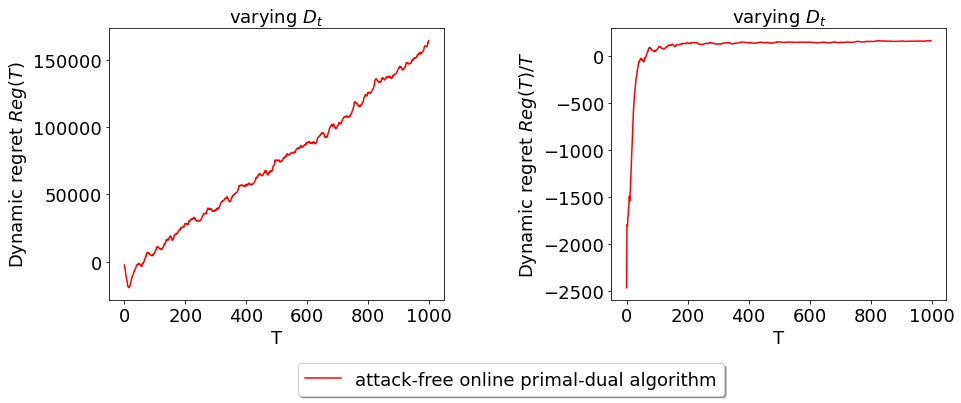

In [14]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret_T,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))

#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.png',format='png', bbox_inches='tight')

In [15]:
#累计的约束违反

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [17]:
sum_thermal_wind_power_station_strategy=np.loadtxt("./data/02_IOS_optimal_parameters_large_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt")
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt")

In [18]:
accumulative_constraint_violation=[]
accumulative_constraint_violation_T=[]
for T in range(1, 1000):
    accumulative_constraint_violation_auxiliary_variable=0
    for t in range(0, T): 
        accumulative_constraint_violation_auxiliary_variable=accumulative_constraint_violation_auxiliary_variable+(1/5)*sum_thermal_wind_power_station_strategy[t+1]-d_power_demand[t+1]
    accumulative_constraint_violation.append(abs(accumulative_constraint_violation_auxiliary_variable))
    accumulative_constraint_violation_T.append(abs(accumulative_constraint_violation_auxiliary_variable)/T)

In [19]:
accumulative_constraint_violation_T

[44.659041904000006,
 48.588688235000006,
 50.17767404400001,
 50.597133816,
 50.0617025008,
 49.094435092333335,
 48.01775363400001,
 45.618576274000006,
 43.794978186444446,
 43.3772240012,
 42.113256910000004,
 39.51540975016667,
 37.42432693138461,
 35.47907485585714,
 32.95265185066667,
 30.7964529975,
 29.044065269764708,
 27.322906778333333,
 25.140582894,
 23.523813484099996,
 22.07049400771428,
 20.62808857154545,
 19.38207418113043,
 18.40012561158333,
 17.005773024879996,
 16.24715421292307,
 15.611331625999993,
 14.674623651214278,
 13.949418119103441,
 13.086789110599993,
 12.27565597806451,
 11.981146109999994,
 11.45002308896969,
 10.98290366511764,
 10.350242845542851,
 9.90136307505555,
 9.554202824702696,
 8.789698991315783,
 8.380869474769224,
 8.166778993549993,
 7.941691134731699,
 7.991343255523801,
 7.8893580349302255,
 7.739064346090902,
 7.632050037599993,
 7.487187183478254,
 7.452334995659568,
 7.391954075749993,
 7.4816416425714225,
 7.518043571559994,
 7.52

In [20]:
#绘图 accumulative_constraint_violation和accumulative_constraint_violation_T

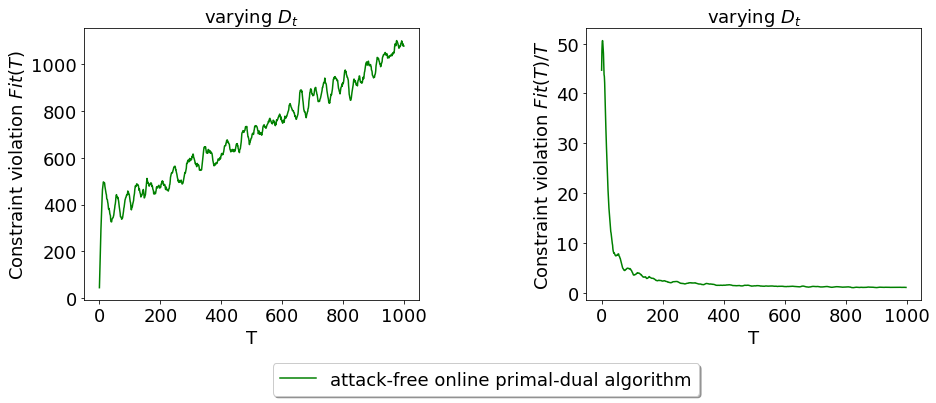

In [21]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation_T,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))


#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.png',format='png', bbox_inches='tight')